<a href="https://colab.research.google.com/github/redwaneaitouammi/AI_Stack_Overflow_Topic_Predict/blob/main/Project4_Stack_Overflow_Questions_Tag_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import os
import re
import string
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

print(tf.__version__)

2.4.1


In [2]:
URL = "http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

data = tf.keras.utils.get_file("stack_overflow_16k.tar.gz",URL,untar=True,cache_dir='.',cache_subdir='')
data_dir = os.path.join(os.path.dirname(data), '')

6053888/6053168 [==============================] - 0s 0us/step


In [3]:
os.listdir(data_dir)

['.config',
 'stack_overflow_16k.tar.gz.tar.gz',
 'train',
 'README.md',
 'test',
 'sample_data']

In [4]:
train_dir=os.path.join(data_dir,'train')
os.listdir(train_dir)

['python', 'csharp', 'javascript', 'java']

In [5]:
sample_file = os.path.join(train_dir,'python/1996.txt')
with open(sample_file) as f:
  print(f.read())

"blank : what is the answer for 1.2 + 0.7? i was playing with the blank command line, and saw that when i type..1.2 + 0.6...i get 1.7999999999999998, but when i type ..1.2 + 0.5...i get 1.7,.moreover, 1.2 + 0.9 gives 2.1000000000000001..does anyone know what's happening in here?.i'm just curious..."



In [6]:
batch_size = 32 
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'train',
    batch_size = batch_size,
    validation_split=0.2, 
    subset='training',
    seed = seed
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [9]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Question", text_batch.numpy()[i])
    print("class", label_batch.numpy()[i])

Question b'"blank8 why is my solution faster than the neat solution? (hackerrank chocolate feast) edit: simplified my solution..edit: removed opinion based secondary question...background: atarted learning blank a week or two ago using hackerranks problems as exercises and stackoverflow search + google as my teacher, i\'ve had some limited experience learning other languages...i did the exercise my own ""noobish learner way"" which i can\'t help but feel is a ""botched job"" when i see ""neat &amp; short"" solutions...however, when submitting both solutions one after another a couple of times i found the ""neat"" solution was quite a bit slower. ..i vaguely remember something about % operations being costly, is mine faster because of no % operations or is there more to it than just that?..exercise: https://www.hackerrank.com/challenges/chocolate-feast..neat solution from discussion:..import blank.io.*;.import blank.util.*;..public class solution {.    static int cc; .    public static 

In [8]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [10]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [11]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'test', 
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [12]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [15]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [16]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [17]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [18]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_question, first_label = text_batch[0], label_batch[0]
print("Question", first_question)
print("tag", raw_train_ds.class_names[first_label])
print("Vectorized Question", vectorize_text(first_question, first_label))

Question tf.Tensor(b'"set blank to quit on exception? i\'m using blank 3..i\'ve been looking around for an answer to this, but i haven\'t found it yet. basically, i\'m running several blank scripts into a game engine, and each script has its own entry point...i\'d rather not add try: except blocks through all of my code, so i was wondering if it\'s at all possible to tell blank to quit (or perhaps assign a custom function to that ""callback"") on finding its first error, regardless of where or what it found? ..currently, the game engine will continue after finding and hitting an error, making it more difficult than necessary to diagnose issues since running into one error may make a subsequent script not work (as it relies on variables that the error-ing script set, for example). any ideas? ..i know that i could redirect the console to a file to allow for easier scrolling, but just capturing the first error and stopping the game prematurely would be really useful...okay, a couple of ex

In [22]:
print("1996 ---> ",vectorize_layer.get_vocabulary()[1996])
print(" 99 ---> ",vectorize_layer.get_vocabulary()[99])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1996 --->  ltlabel
 99 --->  user
Vocabulary size: 10000


In [23]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [24]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [26]:
embedding_dim = 16

In [27]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(max_features+1,embedding_dim),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.GlobalAveragePooling1D(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(4)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 68        
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [31]:
Epochs = 20
history = model.fit(
    train_ds,
    validation_data= val_ds,
    epochs=Epochs
)

Epoch 1/20
200/200 [==============================] - 1s 7ms/step - loss: 0.6271 - accuracy: 0.8222 - val_loss: 0.6703 - val_accuracy: 0.7906
Epoch 2/20
200/200 [==============================] - 1s 7ms/step - loss: 0.6039 - accuracy: 0.8269 - val_loss: 0.6523 - val_accuracy: 0.7956
Epoch 3/20
200/200 [==============================] - 1s 6ms/step - loss: 0.5769 - accuracy: 0.8408 - val_loss: 0.6350 - val_accuracy: 0.7994
Epoch 4/20
200/200 [==============================] - 1s 6ms/step - loss: 0.5546 - accuracy: 0.8444 - val_loss: 0.6196 - val_accuracy: 0.8019
Epoch 5/20
200/200 [==============================] - 2s 8ms/step - loss: 0.5377 - accuracy: 0.8495 - val_loss: 0.6054 - val_accuracy: 0.8031
Epoch 6/20
200/200 [==============================] - 1s 6ms/step - loss: 0.5165 - accuracy: 0.8566 - val_loss: 0.5930 - val_accuracy: 0.8050
Epoch 7/20
200/200 [==============================] - 1s 6ms/step - loss: 0.5000 - accuracy: 0.8648 - val_loss: 0.5814 - val_accuracy: 0.8075
Epoch 

In [32]:
loss, accuracy = model.evaluate(test_ds)
print(
    "Loss: ", loss
)
print(
    "Accuracy", accuracy
)

250/250 [==============================] - 4s 15ms/step - loss: 0.5487 - accuracy: 0.7989
Loss:  0.5486963391304016
Accuracy 0.7988749742507935


In [33]:
history_dict=history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

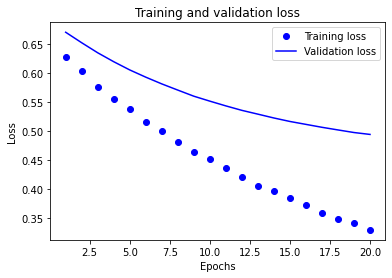

In [35]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs= range(1,len(acc)+1)

plt.plot(epochs,loss,'bo', label='Training loss')
plt.plot(epochs, val_loss,'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

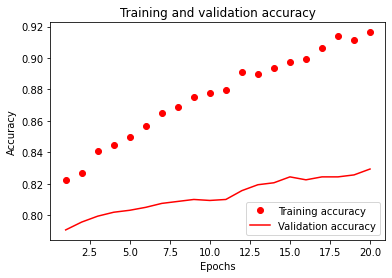

In [36]:
plt.plot(epochs,acc,'ro',label='Training accuracy')
plt.plot(epochs,val_acc,'r',label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [49]:
model_with_txtVect_layer = tf.keras.Sequential([
                                    vectorize_layer,
                                    model,
                                    
])

model_with_txtVect_layer.compile(
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer="adam",
    metrics=['accuracy']
)

loss, accuracy = model_with_txtVect_layer.evaluate(raw_test_ds)

print(accuracy)

250/250 [==============================] - 3s 12ms/step - loss: 0.5361 - accuracy: 0.8019
0.7988749742507935


In [50]:
examples = [ 
  "Python",
  "Csharp",
  "Python"
            ]

In [51]:
predicted_result= model_with_txtVect_layer.predict(examples)
predicted_result

array([[ 0.24996516, -0.08739011,  0.27445853, -0.48593292],
       [ 0.33785817, -0.19738743,  0.24290964, -0.4477184 ],
       [ 0.24996516, -0.08739011,  0.27445853, -0.48593292]],
      dtype=float32)